# Analyze and Plot

## Importing libraries

In [1]:
import pandas as pd
import os
import re
import numpy as np
import sys
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import statsmodels.api as sm
import statsmodels.stats.proportion as prop
import pickle

## Reading in user and retweet network data

In [2]:
#users = pd.read_csv('../data/users_ratings.csv')
users = pd.read_csv('data/users_ratings.csv')
users = users.set_index('userid')

In [3]:
# Get users w/ at least 5 written tweets
u = users[users['orig_total_count']>=5]

In [4]:
#u[['orig_rating']].dropna().to_csv('./data/users_orig_rating.csv')

In [5]:
#u.to_csv('../data/users_orig_rating.csv')

In [6]:
# Retweet network df:
#rt = pd.read_csv('../data/rt_network.csv')
rt = pd.read_csv('data/rt_network.csv')

In [7]:
# Printing attributes of data:
print('Total users: ' + str(len(users)))
print('Total edges: ' + str(len(rt)))
print('Total retweets: ' + str(rt['rt'].sum()))

print('Users on the right: ' + str(len(users[users['orig_rating']>0])))
#print('Edges between the users on the right: ' + str(len(r_r)))
#print('Total retweets on the right: ' + str(r_r['rt'].sum()))

print('Users on the left: ' + str(len(users[users['orig_rating']<0])))
#print('Edges between the users on the left: ' + str(len(r)))
#print('Total retweets on the left: ' + str(r['rt'].sum()))

Total users: 1865559
Total edges: 107562040
Total retweets: 262410320
Users on the right: 147434
Users on the left: 274437


## Functions for simulations

In [8]:
# Returns margin of error for mean of data array:
def mean_confidence_interval(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return (h)

In [9]:
# Selects fraction of IDs are chosen at random to include in network DF subset:
def get_random(r2, frac=1):
    
    us = r2['userid'].unique()
    us_sample = np.random.choice(us, size=int(len(us)*frac), replace=False)
    
    return(r2[r2['userid'].isin(us_sample)])

In [10]:
# Simulates either homophily (direction = 'any') or one-sided homophily (direction = 'right')
# Selects fraction of users with minimal difference in user leanings
def get_closest(r_,direction='any'):
    
    e = r_['orig_rating_ego'].values
    p = r_['orig_rating_peer'].values
    limit = 0.7
    closest=[]
    
    # Create 70% subset with max homophily users based on minimal distance in either direction:
    if direction == 'any':
        
        # For every ego rating in 70% subset of ego ratings:
        for ev in e[0:int(len(e)*limit)]:
            absolute_val_array = np.abs(p - ev) # abs peer polit minus ego polit
            smallest_difference_index = absolute_val_array.argmin()
            
            closest_element = p[smallest_difference_index]
            
            p = np.delete(p,smallest_difference_index)
            closest.append(closest_element)
            
        r_ = r_.iloc[0:len(closest)] # only participants in closest
        r_['orig_rating_peer'] = closest # Creates new column for closest peer ratings
        
    if direction == 'right':
        for ev in e[0:int(len(e)*limit)]:
            diff = p - ev # Returns difference array
            
            # Returns index of minimum difference element, penalizing differences under 0:
            smallest_difference_index = np.where(diff >= 0, diff, diff**2 + 100).argmin()
            
            # Uses index of closest element to grab element:
            closest_element = p[smallest_difference_index]
            
            # Deletes element for next iteration:
            p = np.delete(p,smallest_difference_index)
            
            # Appends element to 'closest' array:
            closest.append(closest_element)
            
        # Returns network subset with closest peer ratings:
        r_ = r_.iloc[0:len(closest)]
        r_['orig_rating_peer'] = closest
        
    return(r_)

In [11]:
# ??? - maybe getting participants furthest from ego
def get_furthest(r_):
    
    e = r_['orig_rating_ego'].values
    p = r_['orig_rating_peer'].values
    diff = p - e
    pos_diff = [x for x in diff if x >= 0]
    r_ = r_.iloc[0:len(pos_diff)]
    r_['orig_rating_peer'] = s[0:len(pos_diff)]
    
    return(r_)

In [12]:
# Runs subsetting for either of the homophily strategies depending on the specified direction:
def baseline_biased(r_,furthest=False,direction='any'):
    
    if furthest == True:
        r_ = get_furthest(r_)
    else:
        r_ = get_closest(r_,direction)
        
    return(r_)

In [13]:
# Gets a random sample of peers:
def baseline_rand(r_,sim_limit):
    
    r_short = r_.iloc[:int((len(r_)*sim_limit))]
    r_short['orig_rating_ego'] = r_['orig_rating_ego'].sample(frac=1).iloc[:int((len(r_)*sim_limit))].values
    r_short['orig_rating_peer'] = r_['orig_rating_peer'].sample(frac=1).iloc[:int((len(r_)*sim_limit))].values
    
    return(r_short)

In [14]:
def get_base_ratings(r,u,thresh=5,baseline='rand'):
    
    """
    Returns mean political leanings of egos and peers, as well as the conditional probability 
    of being connected to more politically extreme person, along with its CI.
    
    It passes the retweet network DF (r), the user DF (u), a minimum retweet treshold (thresh), and the
    baseline model, where baseline = 'rand', 'homo', 'homo_right', or 'empi' depending on the strategy.
    The baseline argument will determine whether to use the baseline_rand or baseline_biased function to subset
    the dataframe, and, if simulating homophily, the direction argument will determine whether it is 
    one-sided or two-sided homophily. The thresh argument will determine the minimum number of retweets at which
    to subset the retweet network DF.
    
    """
    
    # Subsets based on min retweet threshold:
    r1 = r[r['rt']>=thresh]
    
    # Joins subset RT network DF with user DF based on user id and on rt user id:
    r2 = r1.join(u[['orig_rating']], on='userid').join(u[['orig_rating']], on='rt_userid', 
                                   rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
    
    # If statement lines are to perform proper baseline sampling procedure depending on strategy:
    if baseline == 'rand':
        #r2['orig_rating_peer'] = r2['orig_rating_peer'].sample(frac=1).values
        r2 = baseline_rand(r2,0.7)
        
    if baseline == 'homo':
        r2 = baseline_biased(r2.sample(frac=1),furthest=False)
        
    if baseline == 'acro': # does this matter? - maybe not
        r2 = baseline_biased(get_random(r2, .1),furthest=True)
        
    if baseline == 'homo_right':    
        r2 = baseline_biased(r2.sample(frac=1),direction='right')
    
    # Gets mean ego and peer ratings groupbed by user ID:
    ego_rating = r2.groupby('userid')['orig_rating_ego'].mean()
    peer_rating = r2.groupby('userid')['orig_rating_peer'].mean()
    
    # Creates new DF of users and original ratings:
    s = r2.drop_duplicates(subset=['userid'])[['userid','orig_rating_ego']].set_index('userid')
    
    # Joins with mean peer ratings grouped by user ID:
    s = s.join(r2.groupby('userid')['orig_rating_peer'].mean())
    
    # Number of ego ratings smaller than their peers' ratings:
    h = len(s[s['orig_rating_ego']<s['orig_rating_peer']])
    
    peer_prob_higher = h/(len(s))
    peer_prob_higher_ci = peer_prob_higher - prop.proportion_confint(h, len(s), alpha=0.05, method='normal')[0]
    
    return(ego_rating,peer_rating,peer_prob_higher,peer_prob_higher_ci)

In [15]:
# Function to repeat main function multiple times, returning mean probabilities of peers being higher w/mean CI:
def repeat_base_rating(r,u,baseline,direction='any',thresh=5,n=5):
    
    # Initializing series to append to for ego and peer ratings:
    ego_rating = pd.Series(dtype = 'float64')
    peer_rating = pd.Series(dtype = 'float64')
    
    peer_prob_higher = []
    peer_prob_higher_ci = []
    
    # Performs multiple iterations of simulation procedure:
    for i in range(n):
        print(i)
        eb,pb,pphb,pphc = get_base_ratings(r,u,thresh=thresh,baseline=baseline)
        
        # Concats results with series:
        ego_rating = pd.concat([ego_rating, eb])
        peer_rating = pd.concat([peer_rating, pb])
        
        peer_prob_higher.append(pphb)
        peer_prob_higher_ci.append(pphc)
        
    return(ego_rating,peer_rating,np.mean(peer_prob_higher),np.mean(peer_prob_higher_ci))

## Simulating retweet network for right-leaning individuals

In [16]:
orient = 'right' # For conservatives
min_tweets = 5

if orient == 'right':
    u = users[users['orig_rating']>0] # Conservative user ratings are coded as above 0.

# Subset based on min tweet threshold:
u = u[u['orig_total_count']>=min_tweets]

# Subsetting retweet network ID to contain only egos and peers that meet min tweet threshold:
r_r = rt[rt['userid'].isin(u.index) & rt['rt_userid'].isin(u.index)]
#r_r = r_r.sample(frac=0.2)

r_r = r_r[r_r['userid'] != r_r['rt_userid']] # Removes observations where user retweeted self

In [17]:
# r = r_r.copy()
# thresh = 5
# r1 = r[r['rt']>=thresh]
# r2 = r1.join(u[['orig_rating']],on='userid').join(u[['orig_rating']],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
# r2['orig_rating_peer'] = r2['orig_rating_peer'].sample(frac=1).values


In [18]:
# Initializing dictionaries for each model:
baseline = {
    'rand':{},
    'homo':{},
    'homo_right':{},
    'empi':{}
}

In [19]:
# Creating minimum retweet threshold range:
range_start = 3
range_end = 35

# Creating baseline dictionaries for each model at each minimum tweet threshold within range:
for thresh in range(range_start,range_end, 3):
    print(thresh)
    models = ['rand','homo','homo_right','empi']
    for b in models:
        print(b)
        if b == 'homo':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r_r,u,thresh=thresh,baseline='homo',n=5)
        if b == 'homo_right':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r_r,u,thresh=thresh,baseline='homo_right',n=5)
        else:
            ego,peer,peer_higher, peer_higher_ci = get_base_ratings(r_r,u,thresh=thresh,baseline=b)
        baseline[b][thresh] = {'ego':ego.mean(), 'ego_ci':mean_confidence_interval(ego),
                                      'peer':peer.mean(),'peer_ci':mean_confidence_interval(peer),
                                      'peer_prob_higher':peer_higher, 'peer_prob_ci':peer_higher_ci}

# Saving results as pickle file:
#with open('../data/baseline_right_'+str(range_start)+'_'+str(range_end)+'_.pickle', 'wb') as handle:
#    pickle.dump(baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

3
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
6
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
9
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
12
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
15
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
18
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
21
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
24
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
27
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
30
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
33
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi


### Saving results as csv files

In [21]:
x = []
egos_base = []
egos_empi = []
peer_base = []
peer_base_h = []
peer_base_a = []
peer_empi = []

egos_base_ci = []
peer_base_ci = []
peer_base_h_ci = []
peer_base_a_ci = []
peer_empi_ci = []

pphb = [] # Probability peer higher baseline
pphbh = [] # Probability peer higher baseline homophily
pphba = [] # Probability peer higher baseline acrophily
pph = [] # Probability peer higher empirical

pphb_ci = []
pphbh_ci = []
pphba_ci = []
pph_ci = []

# For each min tweet threshold and within each model's dictionary, appends list of ego/peer values + ego/peer CIs:
for k,v in baseline['rand'].items():
    x.append(k)
    egos_base.append(v['ego'])
    egos_base_ci.append(v['ego_ci'])
 
    peer_base.append(v['peer'])
    peer_base_ci.append(v['peer_ci'])
    pphb.append(v['peer_prob_higher'])
    pphb_ci.append(v['peer_prob_ci'])

for k,v in baseline['homo'].items():
    peer_base_h.append(v['peer'])
    peer_base_h_ci.append(v['peer_ci'])
    pphbh.append(v['peer_prob_higher'])
    pphbh_ci.append(v['peer_prob_ci'])
    
for k,v in baseline['homo_right'].items():
    peer_base_a.append(v['peer'])
    peer_base_a_ci.append(v['peer_ci'])
    pphba.append(v['peer_prob_higher'])
    pphba_ci.append(v['peer_prob_ci'])
    
for k,v in baseline['empi'].items():
    egos_empi.append(v['ego'])
    peer_empi.append(v['peer'])
    peer_empi_ci.append(v['peer_ci'])
    pph.append(v['peer_prob_higher'])
    pph_ci.append(v['peer_prob_ci'])

In [23]:
# Creating csv file of expected peer political leanings with CIs for each model plus empirical at each threshold:
pd.DataFrame(list(zip(x, egos_base, peer_base, peer_base_ci, peer_base_h, peer_base_h_ci,
                      peer_base_a,peer_base_a_ci, egos_empi, peer_empi,peer_empi_ci)), 
               columns =['x', 'ego_baseline', 'peer_baseline', 'peer_baseline_ci',
                         'peer_homophily', 'peer_homophily_ci',
                         'peer_homophily_right', 'peer_homophily_right_ci',
                         'ego_empirical', 'peer_empirical', 'peer_empirical_ci']).to_csv('data/leaning_right.csv',index=False)

# Creating csv file of probabilities at each threshold for each model plus empirical:
pd.DataFrame(list(zip(x, pphb, pphb_ci,pphbh,pphbh_ci,pphba,pphba_ci,pph,pph_ci)), 
               columns =['x', 'baseline', 'baseline_ci', 
                         'homophily', 'homophily_ci', 
                         'homophily_right', 'homophily_right_ci',
                         'empirical', 'empirical_ci']).to_csv('data/probability_right.csv',index=False)

### Plotting results

In [12]:
# Colors for plots:
colors={'lightgrey':'#bcc4cd',
        'darkgrey':'#566573',
       'myorange':'#e95c25',
       'myblue':'#4392f1',
       'mygreen':'#00a878'}

In [25]:
df_lr = pd.read_csv('./data/leaning_right.csv')
df_pr = pd.read_csv('./data/probability_right.csv')

In [26]:
df_lr.columns.values

array(['x', 'ego_baseline', 'peer_baseline', 'peer_baseline_ci',
       'peer_homophily', 'peer_homophily_ci', 'peer_homophily_right',
       'peer_homophily_right_ci', 'ego_empirical', 'peer_empirical',
       'peer_empirical_ci'], dtype=object)

In [28]:
x = df_lr['x'].values

peer_empi = df_lr['peer_empirical'].values
peer_empi_ci = df_lr['peer_empirical_ci'].values

peer_base = df_lr['peer_baseline'].values
peer_base_ci = df_lr['peer_baseline_ci'].values

peer_base_h = df_lr['peer_homophily'].values
peer_base_h_ci = df_lr['peer_homophily_ci'].values

peer_base_a = df_lr['peer_homophily_right'].values
peer_base_a_ci = df_lr['peer_homophily_right_ci'].values

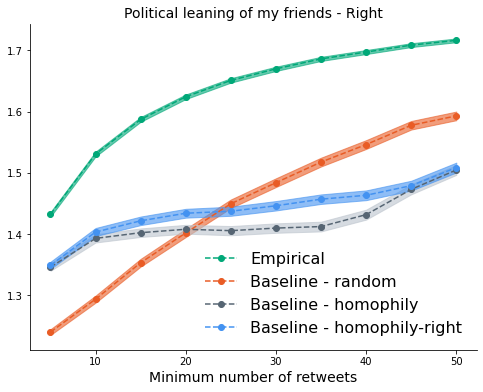

In [32]:
# Plotting political leanings as function of min retweet threshold for each model plus empirical results:
fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x, egos,  '--o', label='Ego', color=colors['myblue'])
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color=colors['myblue'], alpha=0.6)

ax.plot(x, peer_empi,  '--o', label='Empirical', color = colors['mygreen'])
ax.fill_between(x, np.subtract(peer_empi,peer_empi_ci), np.add(peer_empi,peer_empi_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, peer_base,  '--o', label='Baseline - random', color = colors['myorange'])
ax.fill_between(x, np.subtract(peer_base,peer_base_ci), np.add(peer_base,peer_base_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, peer_base_h,  '--o', label='Baseline - homophily', color = colors['darkgrey'])
ax.fill_between(x, np.subtract(peer_base_h,peer_base_h_ci), np.add(peer_base_h,peer_base_h_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, peer_base_a,  '--o', label='Baseline - homophily-right', color = colors['myblue'])
ax.fill_between(x, np.subtract(peer_base_a,peer_base_a_ci), np.add(peer_base_a,peer_base_a_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Political leaning of my friends - Right', fontsize=14)
ax.set_xlabel('Minimum number of retweets', fontsize=14)
ax.legend(fontsize=16,frameon=False)

In [33]:
df_pr.columns.values

array(['x', 'baseline', 'baseline_ci', 'homophily', 'homophily_ci',
       'homophily_right', 'homophily_right_ci', 'empirical',
       'empirical_ci'], dtype=object)

In [35]:
pph = df_pr['empirical'].values
pph_ci = df_pr['empirical_ci'].values

pphb = df_pr['baseline'].values
pphb_ci = df_pr['baseline_ci'].values

pphbh = df_pr['homophily'].values
pphbh_ci = df_pr['homophily_ci'].values

pphba = df_pr['homophily_right'].values
pphba_ci = df_pr['homophily_right_ci'].values

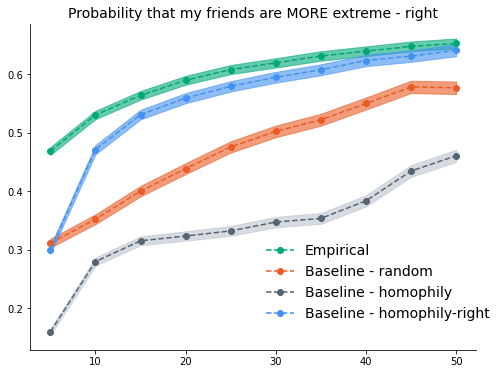

In [36]:
# Plotting probabilities that peers are more extreme as function of min retweet threshold:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, pph,  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(pph,pph_ci), np.add(pph,pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, pphb,  '--o', label='Baseline - random', color=colors['myorange'])
ax.fill_between(x, np.subtract(pphb,pphb_ci), np.add(pphb,pphb_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, pphbh,  '--o', label='Baseline - homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(pphbh,pphbh_ci), np.add(pphbh,pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, pphba,  '--o', label='Baseline - homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(pphba,pphba_ci), np.add(pphba,pphba_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Probability that my friends are MORE extreme - right', fontsize=14)

ax.legend(loc= 'lower left',fontsize=14, bbox_to_anchor=(0.5, 0.05), bbox_transform=ax.transAxes, frameon=False)


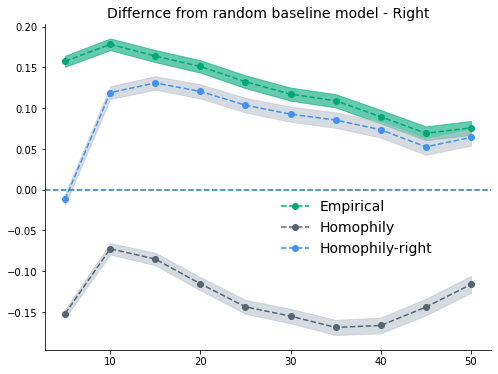

In [37]:
# Plotting difference from random baseline for homophily models and empirical results:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, np.array(pph) - np.array(pphb),  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(np.array(pph) - np.array(pphb),pph_ci), np.add(np.array(pph) - np.array(pphb),pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, np.array(pphbh) - np.array(pphb),  '--o', label='Homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(np.array(pphbh) - np.array(pphb),pphbh_ci), np.add(np.array(pphbh) - np.array(pphb),pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, np.array(pphba) - np.array(pphb),  '--o', label='Homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(np.array(pphba) - np.array(pphb),pphba_ci), np.add(np.array(pphba) - np.array(pphb),pphba_ci), color=colors['lightgrey'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Differnce from random baseline model - Right', fontsize=14)
ax.axhline(y=0, linestyle='dashed')
ax.legend(loc= 'lower left',fontsize=14, bbox_to_anchor=(0.5, 0.25), bbox_transform=ax.transAxes, frameon=False)

## Simulating retweet network of left-leaning individuals

Repeats simulations for liberal participants with only minor alterations in set up.

In [17]:
orient = 'left'
min_tweets = 5

if orient == 'left':
    u = users[users['orig_rating']<0]
    u['orig_rating'] = u['orig_rating'] * -1 # Multiply by -1 because liberal ratings coded as negative
    u['rtw_rating'] = u['rtw_rating'] * -1
    
u = u[u['orig_total_count']>=min_tweets]
    
r = rt[rt['userid'].isin(u.index) & rt['rt_userid'].isin(u.index)]

r = r[r['userid'] != r['rt_userid']]

In [19]:
baseline_left = {
    'rand':{},
    'homo':{},
    'homo_right':{},
    'empi':{}
}

In [20]:
range_start = 5
range_end = 45
for thresh in range(range_start,range_end,5):
    print(thresh)
    models = ['rand','homo','homo_right','empi']
    for b in models:
        print(b)
        if b == 'homo':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r,u,thresh=thresh,baseline='homo',n=1)
        if b == 'homo_right':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r,u,thresh=thresh,baseline='homo_right',n=1)
        else:
            ego,peer,peer_higher, peer_higher_ci = get_base_ratings(r,u,thresh=thresh,baseline=b)
        baseline_left[b][thresh] = {'ego':ego.mean(), 'ego_ci':mean_confidence_interval(ego),
                                      'peer':peer.mean(),'peer_ci':mean_confidence_interval(peer),
                                      'peer_prob_higher':peer_higher, 'peer_prob_ci':peer_higher_ci}
        
#with open('../data/baseline_left_'+str(range_start)+'_'+str(range_end)+'_.pickle', 'wb') as handle:
#    pickle.dump(baseline_left, handle, protocol=pickle.HIGHEST_PROTOCOL)

5
rand
homo
0
homo_right
0
empi
10
rand
homo
0
homo_right
0
empi
15
rand
homo
0
homo_right
0
empi
20
rand
homo
0
homo_right
0
empi
25
rand
homo
0
homo_right
0
empi
30
rand
homo
0
homo_right
0
empi
35
rand
homo
0
homo_right
0
empi
40
rand
homo
0
homo_right
0
empi


### Saving results as csv files

In [21]:
x = []
egos_base = []
peer_base = []
peer_base_h = []
peer_base_a = []
peer_empi = []

egos_ci = []
peer_base_ci = []
peer_base_h_ci = []
peer_base_a_ci = []
peer_empi_ci = []

pphb = []
pphbh = []
pphba = []
pph = []

egos_empi = []
pphb_ci = []
pphbh_ci = []
pphba_ci = []
pph_ci = []

for k,v in baseline_left['rand'].items():
    x.append(k)
    egos_base.append(v['ego'])
    egos_ci.append(v['ego_ci'])
 
    peer_base.append(v['peer'])
    peer_base_ci.append(v['peer_ci'])
    pphb.append(v['peer_prob_higher'])
    pphb_ci.append(v['peer_prob_ci'])

for k,v in baseline_left['homo'].items():
    peer_base_h.append(v['peer'])
    peer_base_h_ci.append(v['peer_ci'])
    pphbh.append(v['peer_prob_higher'])
    pphbh_ci.append(v['peer_prob_ci'])
    
for k,v in baseline_left['homo_right'].items():
    peer_base_a.append(v['peer'])
    peer_base_a_ci.append(v['peer_ci'])
    pphba.append(v['peer_prob_higher'])
    pphba_ci.append(v['peer_prob_ci'])
    
for k,v in baseline_left['empi'].items():
    egos_empi.append(v['ego'])
    peer_empi.append(v['peer'])
    peer_empi_ci.append(v['peer_ci'])
    pph.append(v['peer_prob_higher'])
    pph_ci.append(v['peer_prob_ci'])

In [32]:
pd.DataFrame(list(zip(x, egos_base, peer_base, peer_base_ci, peer_base_h, peer_base_h_ci,
                      peer_base_a, peer_base_a_ci, egos_empi, peer_empi,peer_empi_ci)), 
               columns =['threshold', 'ego_baseline', 'peer_baseline', 'peer_baseline_ci',
                         'peer_homophily', 'peer_homophily_ci',
                         'peer_homophily_right', 'peer_homophily_right_ci',
                         'ego_empirical', 'peer_empirical', 
                         'peer_empirical_ci']).to_csv('./data/leaning_left.csv',index=False)

pd.DataFrame(list(zip(x, pphb, pphb_ci,pphbh,pphbh_ci,pphba,pphba_ci,pph,pph_ci)), 
               columns =['threshold', 'baseline', 'baseline_ci', 
                         'homophily', 'homophily_ci', 
                         'homophily_right', 'homophily_right_ci',
                         'empirical', 'empirical_ci']).to_csv('./data/probability_left.csv',index=False)

### Plotting results

In [52]:
df_ll = pd.read_csv('./data/leaning_left.csv')
df_pl = pd.read_csv('./data/probability_left.csv')

In [41]:
df_ll.columns.values

array(['x', 'ego_baseline', 'peer_baseline', 'peer_baseline_ci',
       'peer_homophily', 'peer_homophily_ci', 'peer_homophily_right',
       'peer_homophily_right_ci', 'ego_empirical', 'peer_empirical',
       'peer_empirical_ci'], dtype=object)

In [39]:
x = df_ll['x'].values

peer_empi = df_ll['peer_empirical'].values
peer_empi_ci = df_ll['peer_empirical_ci'].values

peer_base = df_ll['peer_baseline'].values
peer_base_ci = df_ll['peer_baseline_ci'].values

peer_base_h = df_ll['peer_homophily'].values
peer_base_h_ci = df_ll['peer_homophily_ci'].values

peer_base_a = df_ll['peer_homophily_right'].values
peer_base_a_ci = df_ll['peer_homophily_right_ci'].values

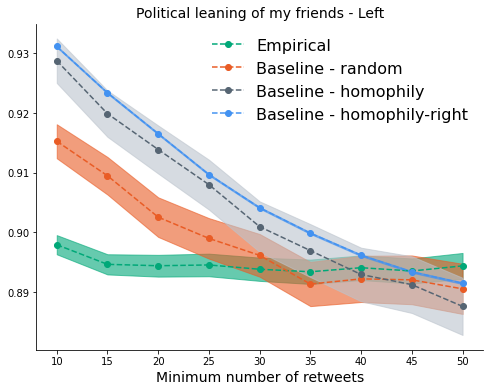

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x, egos,  '--o', label='Ego', color=colors['myblue'])
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color=colors['myblue'], alpha=0.6)

ax.plot(x, peer_empi,  '--o', label='Empirical', color = colors['mygreen'])
ax.fill_between(x, np.subtract(peer_empi,peer_empi_ci), np.add(peer_empi,peer_empi_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, peer_base,  '--o', label='Baseline - random', color = colors['myorange'])
ax.fill_between(x, np.subtract(peer_base,peer_base_ci), np.add(peer_base,peer_base_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, peer_base_h,  '--o', label='Baseline - homophily', color = colors['darkgrey'])
ax.fill_between(x, np.subtract(peer_base_h,peer_base_h_ci), np.add(peer_base_h,peer_base_h_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, peer_base_a,  '--o', label='Baseline - homophily-right', color = colors['myblue'])
ax.fill_between(x, np.subtract(peer_base_a,peer_base_a_ci), np.add(peer_base_a,peer_base_a_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Political leaning of my friends - Left', fontsize=14)
ax.set_xlabel('Minimum number of retweets', fontsize=14)
ax.legend(fontsize=16, frameon=False)

In [54]:
pph = df_pl['empirical'].values
pph_ci = df_pl['empirical_ci'].values

pphb = df_pl['baseline'].values
pphb_ci = df_pl['baseline_ci'].values

pphbh = df_pl['homophily'].values
pphbh_ci = df_pl['homophily_ci'].values

pphba = df_pl['homophily_right'].values
pphba_ci = df_pl['homophily_right_ci'].values

In [55]:
df_pl.head()

,x,baseline,baseline_ci,homophily,homophily_ci,homophily_right,homophily_right_ci,empirical,empirical_ci
0,10,0.413670,0.008162,0.317732,0.006980,0.460087,0.007464,0.419716,0.006915
1,15,0.408334,0.008995,0.316606,0.007781,0.470259,0.008339,0.408013,0.007598
2,20,0.392637,0.009612,0.320780,0.008445,0.473132,0.009059,0.405725,0.008172
3,25,0.397624,0.010302,0.316269,0.009122,0.469795,0.009762,0.405187,0.008744
4,30,0.395471,0.010965,0.310124,0.009686,0.467120,0.010447,0.405893,0.009309


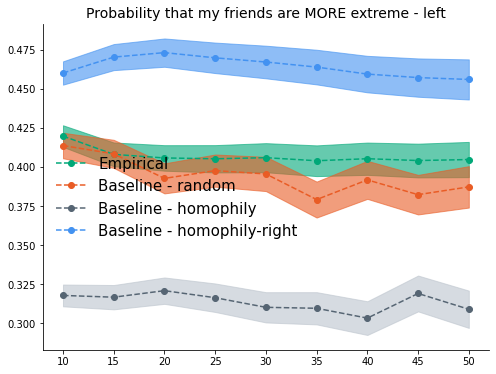

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, pph,  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(pph,pph_ci), np.add(pph,pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, pphb,  '--o', label='Baseline - random', color=colors['myorange'])
ax.fill_between(x, np.subtract(pphb,pphb_ci), np.add(pphb,pphb_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, pphbh,  '--o', label='Baseline - homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(pphbh,pphbh_ci), np.add(pphbh,pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, pphba,  '--o', label='Baseline - homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(pphba,pphba_ci), np.add(pphba,pphba_ci), color=colors['myblue'], alpha=0.6)

ax.set_title('Probability that my friends are MORE extreme - left', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc= 'lower left', bbox_to_anchor=(0, 0.3), bbox_transform=ax.transAxes, fontsize=15, frameon=False)
#ax.legend(fontsize=14)


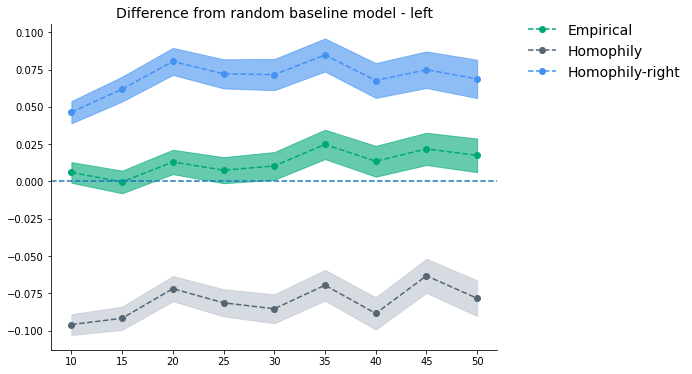

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, np.array(pph) - np.array(pphb),  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(np.array(pph) - np.array(pphb),pph_ci), np.add(np.array(pph) - np.array(pphb),pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, np.array(pphbh) - np.array(pphb),  '--o', label='Homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(np.array(pphbh) - np.array(pphb),pphbh_ci), np.add(np.array(pphbh) - np.array(pphb),pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, np.array(pphba) - np.array(pphb),  '--o', label='Homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(np.array(pphba) - np.array(pphb),pphba_ci), np.add(np.array(pphba) - np.array(pphb),pphba_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Difference from random baseline model - left', fontsize=14)
ax.axhline(y=0, linestyle='dashed')
ax.legend(bbox_to_anchor=(1.04, 1.04), fontsize=14,frameon=False, loc='best')

## Further visualizing ego and peer political leanings

### Functions

In [36]:
# Gets mean user and peer ratings for plotting:
def get_ratings(users,rt,direction='right',which='orig',thresh=5):
    rt2 = rt[rt['rt']>thresh]
    if thresh == 0:
        rt2 = rt2.sample(frac=0.2)
    r = rt2.join(users[['orig_rating','rtw_rating']],on='userid').join(users[['orig_rating','rtw_rating']],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego','rtw_rating':'rtw_rating_ego'})
    
    if direction == 'right':
        r = r[r[which+'_rating_ego']>0]
    if direction == 'left':
        r = r[r[which+'_rating_ego']<0]
        
    ego_rating = r.groupby('userid')[which+'_rating_ego'].mean()
    peer_rating = r.groupby('userid')[which+'_rating_peer'].mean()
    return(ego_rating,peer_rating)

In [38]:
#users = users*users

In [40]:
thresh = 40
direction = 'right'
which = 'orig' #orig or rtw
ego_rating, peer_rating = get_ratings(users,rt,direction=direction,which=which,thresh=thresh)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


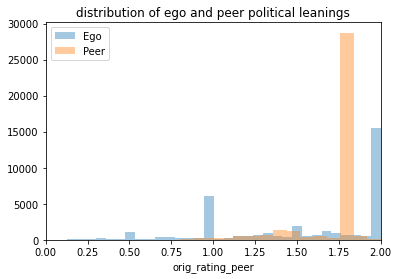

In [41]:
fig, ax = plt.subplots()
sns.distplot(ego_rating, ax=ax, kde=False, label='Ego')
sns.distplot(peer_rating, ax=ax, kde=False, label='Peer')
ax.set_xlim(0,2)
ax.set_title('distribution of ego and peer political leanings')
ax.legend()

plt.show()

In [42]:
# Gets mean peer and ego ratings for conservatives for each threshold:
direction = 'right'
which = 'orig' #orig or rtw
ths = range(5,40)
egos = []
egos_ci = []
peers = []
peers_ci = []
for t in ths:
    ego, peer = get_ratings(users,rt,direction=direction,which=which,thresh=t)
    egos.append(ego.mean())
    egos_ci.append(1.96 * np.std(ego)/np.mean(ego))
    peers.append(peer.mean())
    peers_ci.append(1.96 * np.std(peer)/np.mean(peer))

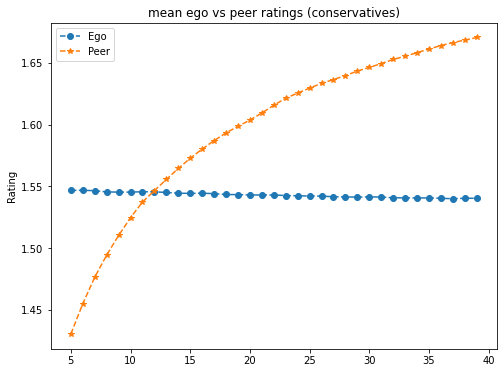

In [43]:
# Plots mean ego vs peer ratings by threshold:

x = range(0,35)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egos,  '--o', label='Ego')
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color='b', alpha=1)
ax.plot(peers, '--*', label = 'Peer')
#ax.fill_between(x, np.subtract(peers,peers_ci), np.add(peers,peers_ci), color='r', alpha=1)
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,40,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,40,5))])
ax.legend()
ax.set_title('mean ego vs peer ratings (conservatives)')

plt.show()

In [44]:
# Gets mean peer and ego ratings for liberals for each threshold:
direction = 'left'
which = 'orig' #orig or rtw
ths = range(5,40)
egosl = []
peersl = []
for t in ths:
    ego, peer = get_ratings(users,rt,direction=direction,which=which,thresh=t)
    egosl.append(ego.mean())
    peersl.append(peer.mean())

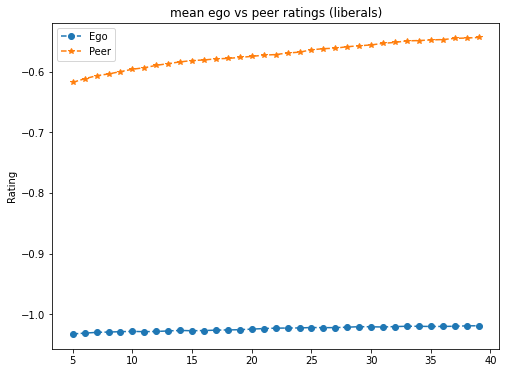

In [49]:
# Plots mean ego and peer ratings by threshold:
x = range(0,35)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egosl,  '--o', label='Ego')
ax.plot(peersl, '--*', label = 'Peer')
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,40,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,40,5))])
ax.legend()
ax.set_title('mean ego vs peer ratings (liberals)')

plt.show()

<AxesSubplot:xlabel='orig_rating', ylabel='Density'>

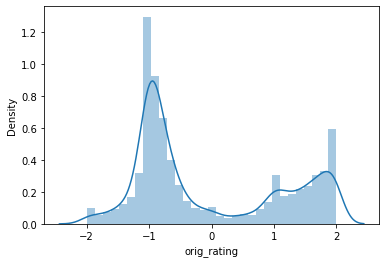

In [50]:
# Distribution of user ratings for users with more than ten tweets:
sns.distplot(users[users['orig_total_count']>10]['orig_rating'], norm_hist=False)

## Mean rating visualizations for egos/peers with tweet counts greater than 3

### Right-leaning network

In [51]:
direction = 'right'
which = 'orig' #orig or rtw
ths = range(5,40)
egosu = []
peersu = []
for t in ths:
    ego, peer = get_ratings(users[users['orig_total_count']>3],rt,direction=direction,which=which,thresh=t)
    egosu.append(ego.mean())
    peersu.append(peer.mean())

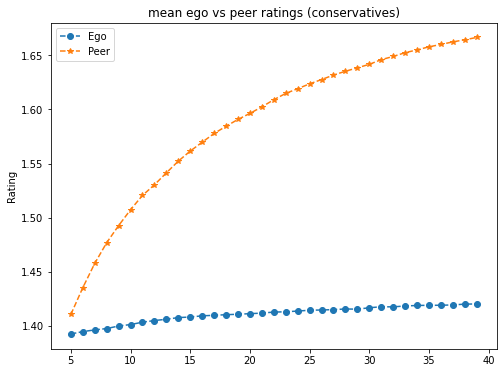

In [52]:
# Plots mean ego vs peer leanings:
x = range(0,35)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egosu,  '--o', label='Ego')
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color='b', alpha=1)
ax.plot(peersu, '--*', label = 'Peer')
#ax.fill_between(x, np.subtract(peers,peers_ci), np.add(peers,peers_ci), color='r', alpha=1)
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,40,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,40,5))])
ax.legend()
ax.set_title('mean ego vs peer ratings (conservatives)')

plt.show()

### Left-leaning network

In [53]:
# Mean ego and peer ratings for liberals with original tweet counts of greater than 3:
direction = 'left'
which = 'orig' #orig or rtw
ths = range(1,100)
egoslu = []
peerslu = []
for t in ths:
    ego, peer = get_ratings(users[users['orig_total_count']>3],rt,direction=direction,which=which,thresh=t)
    egoslu.append(ego.mean())
    peerslu.append(peer.mean())

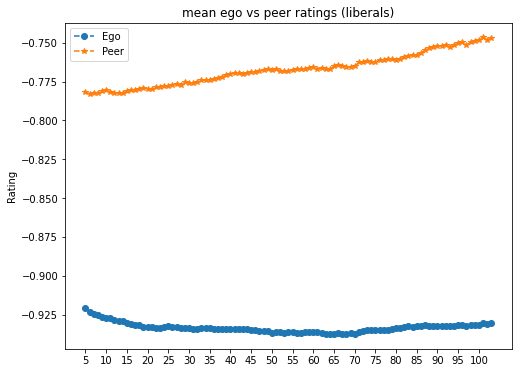

In [54]:
x = range(0,100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egoslu,  '--o', label='Ego')
ax.plot(peerslu, '--*', label = 'Peer')
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,100,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,100,5))])
ax.legend()
ax.set_title('mean ego vs peer ratings (liberals)')

plt.show()

In [55]:
### Extremism vs peer extremism
### Extremism vs number of peers

## Examining differences between ego and peer political leanings

### Right-leaning network

In [56]:
tweet_threshold = 10
orient = 'right'
rt_threshold = 20

active_users = users[users['orig_total_count']>tweet_threshold]
if orient == 'right':
    eligible_users = active_users[active_users['orig_rating']>0]
if orient == 'left':
    eligible_users = active_users[active_users['orig_rating']<0]
    
    
r = rt[rt['userid'].isin(eligible_users.index)]
r = r[r['rt']>rt_threshold]

In [57]:
sample_size = 1000
s = r['userid'].drop_duplicates().sample(n=sample_size)
r = r[r['userid'].isin(s)]

In [58]:
r = r.join(users['orig_rating'],on='userid').join(users['orig_rating'],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
r = r.dropna()

In [59]:
# if orient == 'left':
#     r['orig_rating_ego'] = r['orig_rating_ego'] * -1
#     r['orig_rating_peer'] = r['orig_rating_peer'] * -1

In [60]:
r['userid'].nunique()

985

In [61]:
# Groups by user ID to take mean ratings for themselves and their peers:
d = r[['userid','orig_rating_ego','orig_rating_peer']].groupby('userid').mean()

# Finds difference between ego ratings and their peers' ratings:
d['dif'] = d['orig_rating_ego'] - d['orig_rating_peer']

In [67]:
print('mean difference between ego and peer ratings: {}'.format(d['dif'].mean()))

mean difference between ego and peer ratings: -0.10329912374142293


In [63]:
### Randomize networks

## Relation between the popularity and extremism

### Right-leaning network

In [64]:
tweet_threshold = 10
orient = 'right'

active_users = users[users['orig_total_count']>tweet_threshold]

In [65]:
r = rt[rt['rt_userid'].isin(active_users.index)]
user_pop = rt.groupby('rt_userid')['userid'].nunique()

In [66]:
u = user_pop.to_frame().rename(columns={'userid':'degree'}).join(users['orig_rating'].dropna()).dropna()

In [68]:
if orient == 'right':
    u = u[u['orig_rating']>0]

In [69]:
u.corr()

,degree,orig_rating
degree,1.000000,-0.029257
orig_rating,-0.029257,1.000000
